# VGG网络在CIFAR-10数据集上的训练与测试

本notebook演示如何使用自定义的VGG网络在CIFAR-10数据集上进行训练和测试。

In [1]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from vgg import vgg16, vgg11, vgg13, vgg19

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cuda


In [8]:
# 配置matplotlib中文字体显示
import matplotlib
import platform

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 检查字体设置
print("当前字体设置:", plt.rcParams['font.sans-serif'])
print("matplotlib版本:", matplotlib.__version__)

# 如果仍有字体问题，可以使用英文标签
USE_ENGLISH_LABELS = False  # 设为True使用英文标签避免字体问题

if USE_ENGLISH_LABELS:
    print("使用英文标签以避免字体问题")
else:
    print("使用中文标签")

当前字体设置: ['SimHei', 'DejaVu Sans', 'Arial Unicode MS', 'Microsoft YaHei']
matplotlib版本: 3.8.4
使用中文标签


## 1. 数据准备和预处理

In [2]:
# CIFAR-10数据预处理
# 训练时使用数据增强，测试时只进行标准化
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 加载CIFAR-10数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# CIFAR-10类别名称
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f"训练集大小: {len(trainset)}")
print(f"测试集大小: {len(testset)}")
print(f"类别数: {len(classes)}")

100%|██████████| 170M/170M [00:04<00:00, 38.3MB/s] 



训练集大小: 50000
测试集大小: 10000
类别数: 10


## 2. 可视化数据样本

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

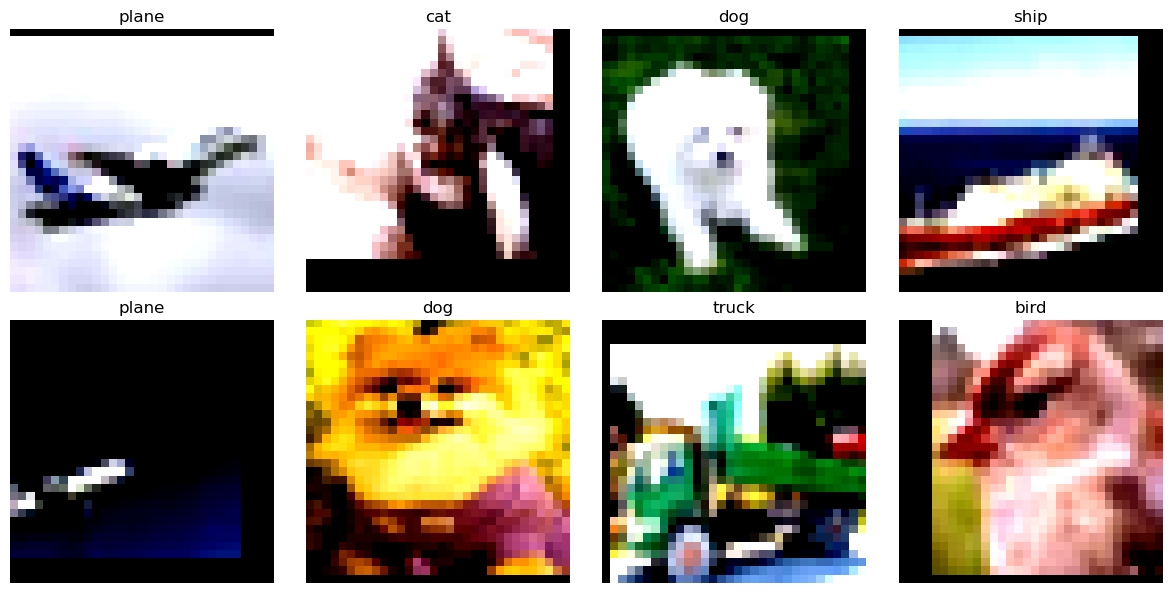

In [3]:
# 可视化一些训练样本
def imshow(img, title=None):
    img = img / 2 + 0.5  # 反标准化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

# 获取一批训练数据
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 显示前8张图片
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    ax = axes[i//4, i%4]
    ax.imshow(np.transpose(images[i].numpy() / 2 + 0.5, (1, 2, 0)))
    ax.set_title(f'{classes[labels[i]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## 3. 模型定义和训练配置

In [4]:
# 创建模型
model = vgg16(num_classes=10).to(device)
print(f"模型参数量: {sum(p.numel() for p in model.parameters()):,}")

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# 学习率调度器
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)

# 训练参数
num_epochs = 200
save_dir = './checkpoints'
os.makedirs(save_dir, exist_ok=True)

模型参数量: 14,990,922


## 4. 训练函数

In [ ]:
def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 根据字体设置选择描述文本
    desc_text = 'Training' if USE_ENGLISH_LABELS else '训练中'
    pbar = tqdm(trainloader, desc=desc_text)
    
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # 更新进度条
        pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.3f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    return running_loss/len(trainloader), 100.*correct/total

def validate(model, testloader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    return test_loss/len(testloader), 100.*correct/total

## 5. 开始训练

In [ ]:
# 训练历史记录
train_losses = []
train_accs = []
test_losses = []
test_accs = []
best_acc = 0

start_text = "Starting training..." if USE_ENGLISH_LABELS else "开始训练..."
print(start_text)

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
    
    # 训练一个epoch
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    
    # 验证
    test_loss, test_acc = validate(model, testloader, criterion, device)
    
    # 更新学习率
    scheduler.step()
    
    # 记录历史
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    if USE_ENGLISH_LABELS:
        print(f'Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%')
        print(f'Test - Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%')
    else:
        print(f'训练 - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%')
        print(f'测试 - Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%')
    
    # 保存最佳模型
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
        }, os.path.join(save_dir, 'vgg16_best.pth'))
        
        best_text = f'New best accuracy: {best_acc:.2f}%, model saved' if USE_ENGLISH_LABELS else f'新的最佳准确率: {best_acc:.2f}%，模型已保存'
        print(best_text)
    
    # 每50个epoch保存一次检查点
    if (epoch + 1) % 50 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'train_accs': train_accs,
            'test_losses': test_losses,
            'test_accs': test_accs,
        }, os.path.join(save_dir, f'vgg16_epoch_{epoch+1}.pth'))

complete_text = f'\nTraining complete! Best test accuracy: {best_acc:.2f}%' if USE_ENGLISH_LABELS else f'\n训练完成！最佳测试准确率: {best_acc:.2f}%'
print(complete_text)

开始训练...

Epoch 1/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:28<00:00, 13.59it/s, Loss=1.635, Acc=37.67%]



训练 - Loss: 1.6354, Acc: 37.67%
测试 - Loss: 1.3397, Acc: 49.80%
新的最佳准确率: 49.80%，模型已保存

Epoch 2/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s, Loss=1.117, Acc=59.71%]



训练 - Loss: 1.1167, Acc: 59.71%
测试 - Loss: 0.9303, Acc: 67.24%
新的最佳准确率: 67.24%，模型已保存

Epoch 3/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.59it/s, Loss=0.878, Acc=69.46%]



训练 - Loss: 0.8780, Acc: 69.46%
测试 - Loss: 0.7844, Acc: 72.25%
新的最佳准确率: 72.25%，模型已保存

Epoch 4/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:27<00:00, 14.38it/s, Loss=0.751, Acc=74.04%]



训练 - Loss: 0.7506, Acc: 74.04%
测试 - Loss: 0.7327, Acc: 74.89%
新的最佳准确率: 74.89%，模型已保存

Epoch 5/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.63it/s, Loss=0.655, Acc=77.56%]



训练 - Loss: 0.6552, Acc: 77.56%
测试 - Loss: 0.6382, Acc: 78.36%
新的最佳准确率: 78.36%，模型已保存

Epoch 6/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s, Loss=0.588, Acc=80.16%]



训练 - Loss: 0.5876, Acc: 80.16%
测试 - Loss: 0.6574, Acc: 78.29%

Epoch 7/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s, Loss=0.536, Acc=81.73%]



训练 - Loss: 0.5356, Acc: 81.73%
测试 - Loss: 0.5591, Acc: 80.18%
新的最佳准确率: 80.18%，模型已保存

Epoch 8/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:27<00:00, 14.03it/s, Loss=0.499, Acc=83.11%]



训练 - Loss: 0.4992, Acc: 83.11%
测试 - Loss: 0.5716, Acc: 81.11%
新的最佳准确率: 81.11%，模型已保存

Epoch 9/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.82it/s, Loss=0.462, Acc=84.52%]



训练 - Loss: 0.4622, Acc: 84.52%
测试 - Loss: 0.5349, Acc: 81.26%
新的最佳准确率: 81.26%，模型已保存

Epoch 10/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.85it/s, Loss=0.427, Acc=85.43%]



训练 - Loss: 0.4272, Acc: 85.43%
测试 - Loss: 0.6665, Acc: 77.93%

Epoch 11/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:27<00:00, 14.20it/s, Loss=0.401, Acc=86.31%]



训练 - Loss: 0.4014, Acc: 86.31%
测试 - Loss: 0.5251, Acc: 82.09%
新的最佳准确率: 82.09%，模型已保存

Epoch 12/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.75it/s, Loss=0.380, Acc=87.28%]



训练 - Loss: 0.3801, Acc: 87.28%
测试 - Loss: 0.5016, Acc: 83.66%
新的最佳准确率: 83.66%，模型已保存

Epoch 13/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:27<00:00, 14.39it/s, Loss=0.358, Acc=87.92%]



训练 - Loss: 0.3581, Acc: 87.92%
测试 - Loss: 0.5182, Acc: 83.42%

Epoch 14/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.78it/s, Loss=0.336, Acc=88.60%]



训练 - Loss: 0.3356, Acc: 88.60%
测试 - Loss: 0.4902, Acc: 83.72%
新的最佳准确率: 83.72%，模型已保存

Epoch 15/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:29<00:00, 13.37it/s, Loss=0.322, Acc=89.16%]



训练 - Loss: 0.3221, Acc: 89.16%
测试 - Loss: 0.4383, Acc: 85.50%
新的最佳准确率: 85.50%，模型已保存

Epoch 16/200
Learning Rate: 0.010000
新的最佳准确率: 85.50%，模型已保存

Epoch 16/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.88it/s, Loss=0.308, Acc=89.57%]



训练 - Loss: 0.3084, Acc: 89.57%
测试 - Loss: 0.4236, Acc: 85.54%
新的最佳准确率: 85.54%，模型已保存

Epoch 17/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 15.03it/s, Loss=0.292, Acc=90.06%]



训练 - Loss: 0.2923, Acc: 90.06%
测试 - Loss: 0.3888, Acc: 87.06%
新的最佳准确率: 87.06%，模型已保存

Epoch 18/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:25<00:00, 15.09it/s, Loss=0.275, Acc=90.52%]



训练 - Loss: 0.2748, Acc: 90.52%
测试 - Loss: 0.4935, Acc: 83.99%

Epoch 19/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.74it/s, Loss=0.264, Acc=90.82%]



训练 - Loss: 0.2638, Acc: 90.82%
测试 - Loss: 0.4388, Acc: 85.62%

Epoch 20/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.71it/s, Loss=0.252, Acc=91.37%]



训练 - Loss: 0.2515, Acc: 91.37%
测试 - Loss: 0.4084, Acc: 86.35%

Epoch 21/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.94it/s, Loss=0.240, Acc=91.74%]



训练 - Loss: 0.2404, Acc: 91.74%
测试 - Loss: 0.3998, Acc: 86.97%

Epoch 22/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:25<00:00, 15.12it/s, Loss=0.235, Acc=91.98%]



训练 - Loss: 0.2350, Acc: 91.98%
测试 - Loss: 0.3961, Acc: 87.31%
新的最佳准确率: 87.31%，模型已保存

Epoch 23/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.65it/s, Loss=0.223, Acc=92.35%]



训练 - Loss: 0.2234, Acc: 92.35%
测试 - Loss: 0.3830, Acc: 87.57%
新的最佳准确率: 87.57%，模型已保存

Epoch 24/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.52it/s, Loss=0.216, Acc=92.58%]



训练 - Loss: 0.2163, Acc: 92.58%
测试 - Loss: 0.3723, Acc: 88.48%
新的最佳准确率: 88.48%，模型已保存

Epoch 25/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:27<00:00, 14.41it/s, Loss=0.209, Acc=92.96%]



训练 - Loss: 0.2086, Acc: 92.96%
测试 - Loss: 0.4438, Acc: 86.46%

Epoch 26/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.68it/s, Loss=0.200, Acc=93.16%]



训练 - Loss: 0.2004, Acc: 93.16%
测试 - Loss: 0.4038, Acc: 87.43%

Epoch 27/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.67it/s, Loss=0.187, Acc=93.58%]



训练 - Loss: 0.1869, Acc: 93.58%
测试 - Loss: 0.3641, Acc: 88.47%

Epoch 28/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.82it/s, Loss=0.187, Acc=93.57%]



训练 - Loss: 0.1865, Acc: 93.57%
测试 - Loss: 0.3863, Acc: 88.24%

Epoch 29/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.77it/s, Loss=0.181, Acc=93.74%]



训练 - Loss: 0.1815, Acc: 93.74%
测试 - Loss: 0.3634, Acc: 88.41%

Epoch 30/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.83it/s, Loss=0.172, Acc=94.27%]



训练 - Loss: 0.1721, Acc: 94.27%
测试 - Loss: 0.3888, Acc: 87.82%

Epoch 31/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.86it/s, Loss=0.169, Acc=94.20%]



训练 - Loss: 0.1690, Acc: 94.20%
测试 - Loss: 0.3732, Acc: 88.46%

Epoch 32/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.82it/s, Loss=0.164, Acc=94.38%]



训练 - Loss: 0.1645, Acc: 94.38%
测试 - Loss: 0.4150, Acc: 87.39%

Epoch 33/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.58it/s, Loss=0.160, Acc=94.70%]



训练 - Loss: 0.1598, Acc: 94.70%
测试 - Loss: 0.3661, Acc: 89.09%
新的最佳准确率: 89.09%，模型已保存

Epoch 34/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.65it/s, Loss=0.153, Acc=94.76%]



训练 - Loss: 0.1533, Acc: 94.76%
测试 - Loss: 0.4028, Acc: 87.63%

Epoch 35/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.71it/s, Loss=0.151, Acc=94.83%]



训练 - Loss: 0.1513, Acc: 94.83%
测试 - Loss: 0.3557, Acc: 88.55%

Epoch 36/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 15.00it/s, Loss=0.145, Acc=94.99%]



训练 - Loss: 0.1449, Acc: 94.99%
测试 - Loss: 0.4143, Acc: 87.86%

Epoch 37/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.96it/s, Loss=0.138, Acc=95.24%]



训练 - Loss: 0.1383, Acc: 95.24%
测试 - Loss: 0.3894, Acc: 88.30%

Epoch 38/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.93it/s, Loss=0.138, Acc=95.24%]



训练 - Loss: 0.1382, Acc: 95.24%
测试 - Loss: 0.3909, Acc: 87.98%

Epoch 39/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 15.03it/s, Loss=0.136, Acc=95.39%]



训练 - Loss: 0.1358, Acc: 95.39%
测试 - Loss: 0.4018, Acc: 88.05%

Epoch 40/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.56it/s, Loss=0.129, Acc=95.58%]



训练 - Loss: 0.1291, Acc: 95.58%
测试 - Loss: 0.3514, Acc: 89.15%
新的最佳准确率: 89.15%，模型已保存

Epoch 41/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.88it/s, Loss=0.127, Acc=95.71%]



训练 - Loss: 0.1271, Acc: 95.71%
测试 - Loss: 0.4138, Acc: 87.92%

Epoch 42/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.93it/s, Loss=0.120, Acc=95.83%]



训练 - Loss: 0.1204, Acc: 95.83%
测试 - Loss: 0.3904, Acc: 88.66%

Epoch 43/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.92it/s, Loss=0.122, Acc=95.87%]



训练 - Loss: 0.1224, Acc: 95.87%
测试 - Loss: 0.3753, Acc: 88.97%

Epoch 44/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 15.01it/s, Loss=0.123, Acc=95.95%]



训练 - Loss: 0.1227, Acc: 95.95%
测试 - Loss: 0.3793, Acc: 88.76%

Epoch 45/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.96it/s, Loss=0.116, Acc=96.03%]



训练 - Loss: 0.1162, Acc: 96.03%
测试 - Loss: 0.3982, Acc: 88.29%

Epoch 46/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.59it/s, Loss=0.115, Acc=96.14%]



训练 - Loss: 0.1151, Acc: 96.14%
测试 - Loss: 0.3797, Acc: 89.08%

Epoch 47/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.60it/s, Loss=0.116, Acc=96.07%]



训练 - Loss: 0.1159, Acc: 96.07%
测试 - Loss: 0.3895, Acc: 88.82%

Epoch 48/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.97it/s, Loss=0.111, Acc=96.18%]



训练 - Loss: 0.1107, Acc: 96.18%
测试 - Loss: 0.3818, Acc: 88.63%

Epoch 49/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.97it/s, Loss=0.110, Acc=96.33%]



训练 - Loss: 0.1104, Acc: 96.33%
测试 - Loss: 0.3705, Acc: 89.20%
新的最佳准确率: 89.20%，模型已保存

Epoch 50/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.76it/s, Loss=0.109, Acc=96.36%]



训练 - Loss: 0.1089, Acc: 96.36%
测试 - Loss: 0.3645, Acc: 89.45%
新的最佳准确率: 89.45%，模型已保存

Epoch 51/200
Learning Rate: 0.010000

Epoch 51/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:25<00:00, 15.16it/s, Loss=0.111, Acc=96.19%]



训练 - Loss: 0.1105, Acc: 96.19%
测试 - Loss: 0.3299, Acc: 90.19%
新的最佳准确率: 90.19%，模型已保存

Epoch 52/200
Learning Rate: 0.010000
新的最佳准确率: 90.19%，模型已保存

Epoch 52/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.60it/s, Loss=0.102, Acc=96.51%]



训练 - Loss: 0.1016, Acc: 96.51%
测试 - Loss: 0.3634, Acc: 89.81%

Epoch 53/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.72it/s, Loss=0.106, Acc=96.46%]



训练 - Loss: 0.1055, Acc: 96.46%
测试 - Loss: 0.4350, Acc: 87.94%

Epoch 54/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s, Loss=0.105, Acc=96.42%]



训练 - Loss: 0.1049, Acc: 96.42%
测试 - Loss: 0.4252, Acc: 88.27%

Epoch 55/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.82it/s, Loss=0.102, Acc=96.64%]



训练 - Loss: 0.1024, Acc: 96.64%
测试 - Loss: 0.3764, Acc: 89.13%

Epoch 56/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.96it/s, Loss=0.101, Acc=96.56%]



训练 - Loss: 0.1007, Acc: 96.56%
测试 - Loss: 0.4055, Acc: 88.59%

Epoch 57/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.96it/s, Loss=0.099, Acc=96.62%]



训练 - Loss: 0.0989, Acc: 96.62%
测试 - Loss: 0.3835, Acc: 89.24%

Epoch 58/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.96it/s, Loss=0.099, Acc=96.66%]



训练 - Loss: 0.0992, Acc: 96.66%
测试 - Loss: 0.3886, Acc: 88.94%

Epoch 59/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.92it/s, Loss=0.097, Acc=96.67%]



训练 - Loss: 0.0966, Acc: 96.67%
测试 - Loss: 0.3734, Acc: 89.47%

Epoch 60/200
Learning Rate: 0.010000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.53it/s, Loss=0.098, Acc=96.65%]



训练 - Loss: 0.0983, Acc: 96.65%
测试 - Loss: 0.4130, Acc: 88.57%

Epoch 61/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.53it/s, Loss=0.042, Acc=98.64%]



训练 - Loss: 0.0424, Acc: 98.64%
测试 - Loss: 0.2880, Acc: 92.10%
新的最佳准确率: 92.10%，模型已保存

Epoch 62/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.95it/s, Loss=0.025, Acc=99.20%]



训练 - Loss: 0.0248, Acc: 99.20%
测试 - Loss: 0.2977, Acc: 92.33%
新的最佳准确率: 92.33%，模型已保存

Epoch 63/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.97it/s, Loss=0.019, Acc=99.39%]



训练 - Loss: 0.0188, Acc: 99.39%
测试 - Loss: 0.3039, Acc: 92.50%
新的最佳准确率: 92.50%，模型已保存

Epoch 64/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.96it/s, Loss=0.017, Acc=99.48%]



训练 - Loss: 0.0167, Acc: 99.48%
测试 - Loss: 0.3043, Acc: 92.56%
新的最佳准确率: 92.56%，模型已保存

Epoch 65/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 15.02it/s, Loss=0.014, Acc=99.59%]



训练 - Loss: 0.0137, Acc: 99.59%
测试 - Loss: 0.3078, Acc: 92.54%

Epoch 66/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.90it/s, Loss=0.012, Acc=99.62%]



训练 - Loss: 0.0118, Acc: 99.62%
测试 - Loss: 0.3228, Acc: 92.39%

Epoch 67/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.59it/s, Loss=0.013, Acc=99.62%]



训练 - Loss: 0.0130, Acc: 99.62%
测试 - Loss: 0.3253, Acc: 92.35%

Epoch 68/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.76it/s, Loss=0.011, Acc=99.68%]



训练 - Loss: 0.0114, Acc: 99.68%
测试 - Loss: 0.3237, Acc: 92.53%

Epoch 69/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.87it/s, Loss=0.010, Acc=99.70%]



训练 - Loss: 0.0102, Acc: 99.70%
测试 - Loss: 0.3381, Acc: 92.49%

Epoch 70/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.80it/s, Loss=0.010, Acc=99.70%]



训练 - Loss: 0.0100, Acc: 99.70%
测试 - Loss: 0.3269, Acc: 92.52%

Epoch 71/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.99it/s, Loss=0.009, Acc=99.72%]



训练 - Loss: 0.0093, Acc: 99.72%
测试 - Loss: 0.3391, Acc: 92.53%

Epoch 72/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.95it/s, Loss=0.009, Acc=99.73%]



训练 - Loss: 0.0091, Acc: 99.73%
测试 - Loss: 0.3394, Acc: 92.37%

Epoch 73/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 15.04it/s, Loss=0.008, Acc=99.74%]



训练 - Loss: 0.0079, Acc: 99.74%
测试 - Loss: 0.3374, Acc: 92.65%
新的最佳准确率: 92.65%，模型已保存

Epoch 74/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:27<00:00, 14.41it/s, Loss=0.008, Acc=99.74%]



训练 - Loss: 0.0081, Acc: 99.74%
测试 - Loss: 0.3442, Acc: 92.58%

Epoch 75/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:25<00:00, 15.05it/s, Loss=0.007, Acc=99.79%]



训练 - Loss: 0.0069, Acc: 99.79%
测试 - Loss: 0.3386, Acc: 92.42%

Epoch 76/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.91it/s, Loss=0.007, Acc=99.81%]



训练 - Loss: 0.0068, Acc: 99.81%
测试 - Loss: 0.3436, Acc: 92.60%

Epoch 77/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.73it/s, Loss=0.007, Acc=99.80%]



训练 - Loss: 0.0067, Acc: 99.80%
测试 - Loss: 0.3481, Acc: 92.29%

Epoch 78/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.89it/s, Loss=0.006, Acc=99.82%]



训练 - Loss: 0.0061, Acc: 99.82%
测试 - Loss: 0.3478, Acc: 92.47%

Epoch 79/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.86it/s, Loss=0.006, Acc=99.81%]



训练 - Loss: 0.0065, Acc: 99.81%
测试 - Loss: 0.3470, Acc: 92.39%

Epoch 80/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.53it/s, Loss=0.006, Acc=99.84%]



训练 - Loss: 0.0058, Acc: 99.84%
测试 - Loss: 0.3494, Acc: 92.54%

Epoch 81/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:27<00:00, 14.28it/s, Loss=0.007, Acc=99.79%]



训练 - Loss: 0.0068, Acc: 99.79%
测试 - Loss: 0.3417, Acc: 92.46%

Epoch 82/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.87it/s, Loss=0.007, Acc=99.81%]



训练 - Loss: 0.0067, Acc: 99.81%
测试 - Loss: 0.3444, Acc: 92.57%

Epoch 83/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.73it/s, Loss=0.006, Acc=99.81%]



训练 - Loss: 0.0063, Acc: 99.81%
测试 - Loss: 0.3519, Acc: 92.52%

Epoch 84/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.82it/s, Loss=0.007, Acc=99.78%]



训练 - Loss: 0.0068, Acc: 99.78%
测试 - Loss: 0.3571, Acc: 92.41%

Epoch 85/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.92it/s, Loss=0.006, Acc=99.82%]



训练 - Loss: 0.0064, Acc: 99.82%
测试 - Loss: 0.3553, Acc: 92.38%

Epoch 86/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.72it/s, Loss=0.006, Acc=99.82%]



训练 - Loss: 0.0059, Acc: 99.82%
测试 - Loss: 0.3517, Acc: 92.57%

Epoch 87/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.61it/s, Loss=0.006, Acc=99.82%]



训练 - Loss: 0.0056, Acc: 99.82%
测试 - Loss: 0.3471, Acc: 92.52%

Epoch 88/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.57it/s, Loss=0.005, Acc=99.85%]



训练 - Loss: 0.0052, Acc: 99.85%
测试 - Loss: 0.3488, Acc: 92.54%

Epoch 89/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.90it/s, Loss=0.005, Acc=99.84%]



训练 - Loss: 0.0048, Acc: 99.84%
测试 - Loss: 0.3540, Acc: 92.57%

Epoch 90/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.98it/s, Loss=0.005, Acc=99.87%]



训练 - Loss: 0.0045, Acc: 99.87%
测试 - Loss: 0.3557, Acc: 92.62%

Epoch 91/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.64it/s, Loss=0.005, Acc=99.85%]



训练 - Loss: 0.0050, Acc: 99.85%
测试 - Loss: 0.3598, Acc: 92.54%

Epoch 92/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.95it/s, Loss=0.005, Acc=99.85%]



训练 - Loss: 0.0050, Acc: 99.85%
测试 - Loss: 0.3595, Acc: 92.83%
新的最佳准确率: 92.83%，模型已保存

Epoch 93/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 15.00it/s, Loss=0.005, Acc=99.85%]



训练 - Loss: 0.0048, Acc: 99.85%
测试 - Loss: 0.3523, Acc: 92.68%

Epoch 94/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.52it/s, Loss=0.004, Acc=99.90%]



训练 - Loss: 0.0041, Acc: 99.90%
测试 - Loss: 0.3622, Acc: 92.31%

Epoch 95/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.57it/s, Loss=0.004, Acc=99.89%]



训练 - Loss: 0.0038, Acc: 99.89%
测试 - Loss: 0.3531, Acc: 92.55%

Epoch 96/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.94it/s, Loss=0.004, Acc=99.90%]



训练 - Loss: 0.0037, Acc: 99.90%
测试 - Loss: 0.3552, Acc: 92.59%

Epoch 97/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.83it/s, Loss=0.004, Acc=99.89%]



训练 - Loss: 0.0038, Acc: 99.89%
测试 - Loss: 0.3656, Acc: 92.34%

Epoch 98/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.86it/s, Loss=0.004, Acc=99.87%]



训练 - Loss: 0.0042, Acc: 99.87%
测试 - Loss: 0.3601, Acc: 92.62%

Epoch 99/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.88it/s, Loss=0.005, Acc=99.86%]



训练 - Loss: 0.0047, Acc: 99.86%
测试 - Loss: 0.3649, Acc: 92.64%

Epoch 100/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.91it/s, Loss=0.005, Acc=99.88%]



训练 - Loss: 0.0047, Acc: 99.88%
测试 - Loss: 0.3554, Acc: 92.60%

Epoch 101/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.50it/s, Loss=0.005, Acc=99.87%]



训练 - Loss: 0.0047, Acc: 99.87%
测试 - Loss: 0.3481, Acc: 92.50%

Epoch 102/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.93it/s, Loss=0.004, Acc=99.87%]



训练 - Loss: 0.0045, Acc: 99.87%
测试 - Loss: 0.3528, Acc: 92.61%

Epoch 103/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.92it/s, Loss=0.005, Acc=99.86%]



训练 - Loss: 0.0049, Acc: 99.86%
测试 - Loss: 0.3614, Acc: 92.47%

Epoch 104/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.98it/s, Loss=0.004, Acc=99.91%]



训练 - Loss: 0.0035, Acc: 99.91%
测试 - Loss: 0.3491, Acc: 92.70%

Epoch 105/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.84it/s, Loss=0.005, Acc=99.88%]



训练 - Loss: 0.0047, Acc: 99.88%
测试 - Loss: 0.3565, Acc: 92.64%

Epoch 106/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.97it/s, Loss=0.004, Acc=99.88%]



训练 - Loss: 0.0044, Acc: 99.88%
测试 - Loss: 0.3539, Acc: 92.45%

Epoch 107/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.86it/s, Loss=0.004, Acc=99.86%]



训练 - Loss: 0.0043, Acc: 99.86%
测试 - Loss: 0.3561, Acc: 92.53%

Epoch 108/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:27<00:00, 14.41it/s, Loss=0.005, Acc=99.86%]



训练 - Loss: 0.0046, Acc: 99.86%
测试 - Loss: 0.3571, Acc: 92.35%

Epoch 109/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.80it/s, Loss=0.004, Acc=99.86%]



训练 - Loss: 0.0045, Acc: 99.86%
测试 - Loss: 0.3569, Acc: 92.48%

Epoch 110/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.92it/s, Loss=0.004, Acc=99.87%]



训练 - Loss: 0.0045, Acc: 99.87%
测试 - Loss: 0.3508, Acc: 92.77%

Epoch 111/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.76it/s, Loss=0.005, Acc=99.86%]



训练 - Loss: 0.0046, Acc: 99.86%
测试 - Loss: 0.3498, Acc: 92.62%

Epoch 112/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 15.01it/s, Loss=0.004, Acc=99.88%]



训练 - Loss: 0.0041, Acc: 99.88%
测试 - Loss: 0.3438, Acc: 92.71%

Epoch 113/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 15.03it/s, Loss=0.004, Acc=99.91%]



训练 - Loss: 0.0038, Acc: 99.91%
测试 - Loss: 0.3495, Acc: 92.74%

Epoch 114/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.54it/s, Loss=0.004, Acc=99.89%]



训练 - Loss: 0.0037, Acc: 99.89%
测试 - Loss: 0.3514, Acc: 92.66%

Epoch 115/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.61it/s, Loss=0.004, Acc=99.89%]



训练 - Loss: 0.0039, Acc: 99.89%
测试 - Loss: 0.3523, Acc: 92.62%

Epoch 116/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:25<00:00, 15.05it/s, Loss=0.004, Acc=99.90%]



训练 - Loss: 0.0038, Acc: 99.90%
测试 - Loss: 0.3429, Acc: 92.76%

Epoch 117/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.92it/s, Loss=0.003, Acc=99.92%]



训练 - Loss: 0.0032, Acc: 99.92%
测试 - Loss: 0.3483, Acc: 92.52%

Epoch 118/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.82it/s, Loss=0.004, Acc=99.89%]



训练 - Loss: 0.0040, Acc: 99.89%
测试 - Loss: 0.3477, Acc: 92.64%

Epoch 119/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.88it/s, Loss=0.004, Acc=99.90%]



训练 - Loss: 0.0040, Acc: 99.90%
测试 - Loss: 0.3490, Acc: 92.63%

Epoch 120/200
Learning Rate: 0.002000


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.77it/s, Loss=0.005, Acc=99.87%]



训练 - Loss: 0.0046, Acc: 99.87%
测试 - Loss: 0.3586, Acc: 92.47%

Epoch 121/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.58it/s, Loss=0.003, Acc=99.91%]



训练 - Loss: 0.0031, Acc: 99.91%
测试 - Loss: 0.3431, Acc: 92.60%

Epoch 122/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.51it/s, Loss=0.002, Acc=99.95%]



训练 - Loss: 0.0025, Acc: 99.95%
测试 - Loss: 0.3395, Acc: 92.73%

Epoch 123/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.96it/s, Loss=0.002, Acc=99.95%]



训练 - Loss: 0.0022, Acc: 99.95%
测试 - Loss: 0.3401, Acc: 92.84%
新的最佳准确率: 92.84%，模型已保存

Epoch 124/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.79it/s, Loss=0.002, Acc=99.95%]



训练 - Loss: 0.0022, Acc: 99.95%
测试 - Loss: 0.3322, Acc: 92.77%

Epoch 125/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.62it/s, Loss=0.002, Acc=99.96%]



训练 - Loss: 0.0020, Acc: 99.96%
测试 - Loss: 0.3340, Acc: 92.87%
新的最佳准确率: 92.87%，模型已保存

Epoch 126/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.99it/s, Loss=0.002, Acc=99.96%]



训练 - Loss: 0.0018, Acc: 99.96%
测试 - Loss: 0.3338, Acc: 92.87%

Epoch 127/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.81it/s, Loss=0.002, Acc=99.97%]



训练 - Loss: 0.0017, Acc: 99.97%
测试 - Loss: 0.3296, Acc: 92.96%
新的最佳准确率: 92.96%，模型已保存

Epoch 128/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.58it/s, Loss=0.002, Acc=99.96%]



训练 - Loss: 0.0019, Acc: 99.96%
测试 - Loss: 0.3300, Acc: 92.94%

Epoch 129/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.61it/s, Loss=0.002, Acc=99.95%]



训练 - Loss: 0.0020, Acc: 99.95%
测试 - Loss: 0.3281, Acc: 92.90%

Epoch 130/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.74it/s, Loss=0.002, Acc=99.97%]



训练 - Loss: 0.0016, Acc: 99.97%
测试 - Loss: 0.3306, Acc: 92.91%

Epoch 131/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.69it/s, Loss=0.002, Acc=99.98%]



训练 - Loss: 0.0015, Acc: 99.98%
测试 - Loss: 0.3294, Acc: 93.01%
新的最佳准确率: 93.01%，模型已保存

Epoch 132/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.71it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0014, Acc: 99.98%
测试 - Loss: 0.3288, Acc: 92.96%

Epoch 133/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.88it/s, Loss=0.002, Acc=99.97%]



训练 - Loss: 0.0018, Acc: 99.97%
测试 - Loss: 0.3304, Acc: 92.93%

Epoch 134/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.95it/s, Loss=0.002, Acc=99.95%]



训练 - Loss: 0.0018, Acc: 99.95%
测试 - Loss: 0.3300, Acc: 92.87%

Epoch 135/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.51it/s, Loss=0.002, Acc=99.97%]



训练 - Loss: 0.0016, Acc: 99.97%
测试 - Loss: 0.3280, Acc: 93.08%
新的最佳准确率: 93.08%，模型已保存

Epoch 136/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.93it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0015, Acc: 99.98%
测试 - Loss: 0.3287, Acc: 92.89%

Epoch 137/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 15.02it/s, Loss=0.002, Acc=99.97%]



训练 - Loss: 0.0016, Acc: 99.97%
测试 - Loss: 0.3261, Acc: 93.00%

Epoch 138/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.80it/s, Loss=0.002, Acc=99.98%]



训练 - Loss: 0.0016, Acc: 99.98%
测试 - Loss: 0.3284, Acc: 92.92%

Epoch 139/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.87it/s, Loss=0.002, Acc=99.97%]



训练 - Loss: 0.0017, Acc: 99.97%
测试 - Loss: 0.3276, Acc: 93.03%

Epoch 140/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.87it/s, Loss=0.001, Acc=99.97%]



训练 - Loss: 0.0014, Acc: 99.97%
测试 - Loss: 0.3265, Acc: 93.03%

Epoch 141/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.60it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0014, Acc: 99.98%
测试 - Loss: 0.3265, Acc: 93.04%

Epoch 142/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.53it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0014, Acc: 99.98%
测试 - Loss: 0.3274, Acc: 92.94%

Epoch 143/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.90it/s, Loss=0.001, Acc=99.99%]



训练 - Loss: 0.0014, Acc: 99.99%
测试 - Loss: 0.3304, Acc: 92.89%

Epoch 144/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.83it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0014, Acc: 99.98%
测试 - Loss: 0.3248, Acc: 92.98%

Epoch 145/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.83it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0014, Acc: 99.98%
测试 - Loss: 0.3241, Acc: 93.07%

Epoch 146/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.92it/s, Loss=0.001, Acc=99.99%] 



训练 - Loss: 0.0011, Acc: 99.99%
测试 - Loss: 0.3246, Acc: 93.04%

Epoch 147/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.76it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0014, Acc: 99.98%
测试 - Loss: 0.3245, Acc: 93.02%

Epoch 148/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.54it/s, Loss=0.002, Acc=99.97%]



训练 - Loss: 0.0016, Acc: 99.97%
测试 - Loss: 0.3250, Acc: 93.04%

Epoch 149/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:27<00:00, 14.45it/s, Loss=0.001, Acc=99.97%]



训练 - Loss: 0.0015, Acc: 99.97%
测试 - Loss: 0.3255, Acc: 93.01%

Epoch 150/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.82it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0013, Acc: 99.98%
测试 - Loss: 0.3265, Acc: 93.07%

Epoch 151/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.75it/s, Loss=0.001, Acc=99.99%]



训练 - Loss: 0.0012, Acc: 99.99%
测试 - Loss: 0.3286, Acc: 92.96%

Epoch 152/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.85it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0013, Acc: 99.98%
测试 - Loss: 0.3253, Acc: 93.11%
新的最佳准确率: 93.11%，模型已保存

Epoch 153/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.85it/s, Loss=0.001, Acc=99.99%] 



训练 - Loss: 0.0012, Acc: 99.99%
测试 - Loss: 0.3244, Acc: 93.06%

Epoch 154/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.82it/s, Loss=0.001, Acc=100.00%]



训练 - Loss: 0.0011, Acc: 100.00%
测试 - Loss: 0.3247, Acc: 93.08%

Epoch 155/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:27<00:00, 14.34it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0013, Acc: 99.98%
测试 - Loss: 0.3250, Acc: 93.10%

Epoch 156/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:27<00:00, 14.38it/s, Loss=0.001, Acc=100.00%]



训练 - Loss: 0.0012, Acc: 100.00%
测试 - Loss: 0.3276, Acc: 92.89%

Epoch 157/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 15.03it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0013, Acc: 99.98%
测试 - Loss: 0.3272, Acc: 92.98%

Epoch 158/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.97it/s, Loss=0.001, Acc=99.99%]



训练 - Loss: 0.0012, Acc: 99.99%
测试 - Loss: 0.3254, Acc: 93.03%

Epoch 159/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.82it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0014, Acc: 99.98%
测试 - Loss: 0.3257, Acc: 93.02%

Epoch 160/200
Learning Rate: 0.000400


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.89it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0013, Acc: 99.98%
测试 - Loss: 0.3253, Acc: 92.96%

Epoch 161/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.98it/s, Loss=0.001, Acc=100.00%]



训练 - Loss: 0.0010, Acc: 100.00%
测试 - Loss: 0.3266, Acc: 92.97%

Epoch 162/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.55it/s, Loss=0.001, Acc=99.99%]



训练 - Loss: 0.0012, Acc: 99.99%
测试 - Loss: 0.3248, Acc: 92.97%

Epoch 163/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 15.03it/s, Loss=0.001, Acc=100.00%]



训练 - Loss: 0.0011, Acc: 100.00%
测试 - Loss: 0.3257, Acc: 93.06%

Epoch 164/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.87it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0013, Acc: 99.98%
测试 - Loss: 0.3263, Acc: 93.06%

Epoch 165/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.74it/s, Loss=0.001, Acc=99.99%]



训练 - Loss: 0.0013, Acc: 99.99%
测试 - Loss: 0.3242, Acc: 93.07%

Epoch 166/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.85it/s, Loss=0.001, Acc=99.99%]



训练 - Loss: 0.0012, Acc: 99.99%
测试 - Loss: 0.3243, Acc: 93.02%

Epoch 167/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.74it/s, Loss=0.001, Acc=99.99%] 



训练 - Loss: 0.0011, Acc: 99.99%
测试 - Loss: 0.3238, Acc: 93.07%

Epoch 168/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.70it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0012, Acc: 99.98%
测试 - Loss: 0.3241, Acc: 93.12%
新的最佳准确率: 93.12%，模型已保存

Epoch 169/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:27<00:00, 14.45it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0013, Acc: 99.98%
测试 - Loss: 0.3246, Acc: 93.04%

Epoch 170/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.79it/s, Loss=0.001, Acc=99.97%]



训练 - Loss: 0.0013, Acc: 99.97%
测试 - Loss: 0.3237, Acc: 93.08%

Epoch 171/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.74it/s, Loss=0.001, Acc=99.99%]



训练 - Loss: 0.0011, Acc: 99.99%
测试 - Loss: 0.3248, Acc: 92.98%

Epoch 172/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.87it/s, Loss=0.001, Acc=99.99%] 



训练 - Loss: 0.0010, Acc: 99.99%
测试 - Loss: 0.3234, Acc: 93.06%

Epoch 173/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.97it/s, Loss=0.001, Acc=99.99%]



训练 - Loss: 0.0012, Acc: 99.99%
测试 - Loss: 0.3245, Acc: 92.92%

Epoch 174/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.91it/s, Loss=0.001, Acc=99.97%]



训练 - Loss: 0.0013, Acc: 99.97%
测试 - Loss: 0.3251, Acc: 92.97%

Epoch 175/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.49it/s, Loss=0.001, Acc=100.00%]



训练 - Loss: 0.0010, Acc: 100.00%
测试 - Loss: 0.3256, Acc: 92.97%

Epoch 176/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:27<00:00, 14.46it/s, Loss=0.001, Acc=100.00%]



训练 - Loss: 0.0011, Acc: 100.00%
测试 - Loss: 0.3245, Acc: 93.02%

Epoch 177/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.85it/s, Loss=0.001, Acc=99.99%] 



训练 - Loss: 0.0011, Acc: 99.99%
测试 - Loss: 0.3237, Acc: 92.96%

Epoch 178/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.83it/s, Loss=0.001, Acc=99.99%] 



训练 - Loss: 0.0011, Acc: 99.99%
测试 - Loss: 0.3234, Acc: 93.07%

Epoch 179/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.72it/s, Loss=0.001, Acc=99.99%]



训练 - Loss: 0.0010, Acc: 99.99%
测试 - Loss: 0.3242, Acc: 93.14%
新的最佳准确率: 93.14%，模型已保存

Epoch 180/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.71it/s, Loss=0.001, Acc=99.99%] 



训练 - Loss: 0.0012, Acc: 99.99%
测试 - Loss: 0.3237, Acc: 93.11%

Epoch 181/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.83it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0012, Acc: 99.98%
测试 - Loss: 0.3229, Acc: 92.93%

Epoch 182/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:27<00:00, 14.24it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0012, Acc: 99.98%
测试 - Loss: 0.3278, Acc: 92.96%

Epoch 183/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s, Loss=0.001, Acc=99.99%]



训练 - Loss: 0.0012, Acc: 99.99%
测试 - Loss: 0.3231, Acc: 93.09%

Epoch 184/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.71it/s, Loss=0.001, Acc=100.00%]



训练 - Loss: 0.0010, Acc: 100.00%
测试 - Loss: 0.3228, Acc: 93.01%

Epoch 185/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.83it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0012, Acc: 99.98%
测试 - Loss: 0.3245, Acc: 93.06%

Epoch 186/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.78it/s, Loss=0.001, Acc=99.99%]



训练 - Loss: 0.0011, Acc: 99.99%
测试 - Loss: 0.3237, Acc: 93.12%

Epoch 187/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.73it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0012, Acc: 99.98%
测试 - Loss: 0.3240, Acc: 93.07%

Epoch 188/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.73it/s, Loss=0.001, Acc=99.99%]



训练 - Loss: 0.0011, Acc: 99.99%
测试 - Loss: 0.3261, Acc: 93.00%

Epoch 189/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.64it/s, Loss=0.001, Acc=99.99%] 



训练 - Loss: 0.0010, Acc: 99.99%
测试 - Loss: 0.3228, Acc: 93.04%

Epoch 190/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.65it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0012, Acc: 99.98%
测试 - Loss: 0.3240, Acc: 93.06%

Epoch 191/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.54it/s, Loss=0.001, Acc=99.99%]



训练 - Loss: 0.0012, Acc: 99.99%
测试 - Loss: 0.3239, Acc: 92.99%

Epoch 192/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.74it/s, Loss=0.001, Acc=99.99%]



训练 - Loss: 0.0010, Acc: 99.99%
测试 - Loss: 0.3232, Acc: 93.01%

Epoch 193/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.87it/s, Loss=0.001, Acc=99.99%]



训练 - Loss: 0.0010, Acc: 99.99%
测试 - Loss: 0.3244, Acc: 92.95%

Epoch 194/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.85it/s, Loss=0.001, Acc=99.99%] 



训练 - Loss: 0.0011, Acc: 99.99%
测试 - Loss: 0.3239, Acc: 92.94%

Epoch 195/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.49it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0011, Acc: 99.98%
测试 - Loss: 0.3221, Acc: 93.14%

Epoch 196/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.60it/s, Loss=0.001, Acc=99.99%] 



训练 - Loss: 0.0011, Acc: 99.99%
测试 - Loss: 0.3227, Acc: 93.03%

Epoch 197/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.69it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0012, Acc: 99.98%
测试 - Loss: 0.3247, Acc: 93.01%

Epoch 198/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.90it/s, Loss=0.001, Acc=99.98%]



训练 - Loss: 0.0011, Acc: 99.98%
测试 - Loss: 0.3223, Acc: 93.15%
新的最佳准确率: 93.15%，模型已保存

Epoch 199/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.72it/s, Loss=0.001, Acc=99.99%]



训练 - Loss: 0.0011, Acc: 99.99%
测试 - Loss: 0.3223, Acc: 93.03%

Epoch 200/200
Learning Rate: 0.000080


训练中: 100%|██████████| 391/391 [00:26<00:00, 14.70it/s, Loss=0.001, Acc=99.99%]



训练 - Loss: 0.0010, Acc: 99.99%
测试 - Loss: 0.3217, Acc: 93.04%

训练完成！最佳测试准确率: 93.15%


## 6. 可视化训练过程

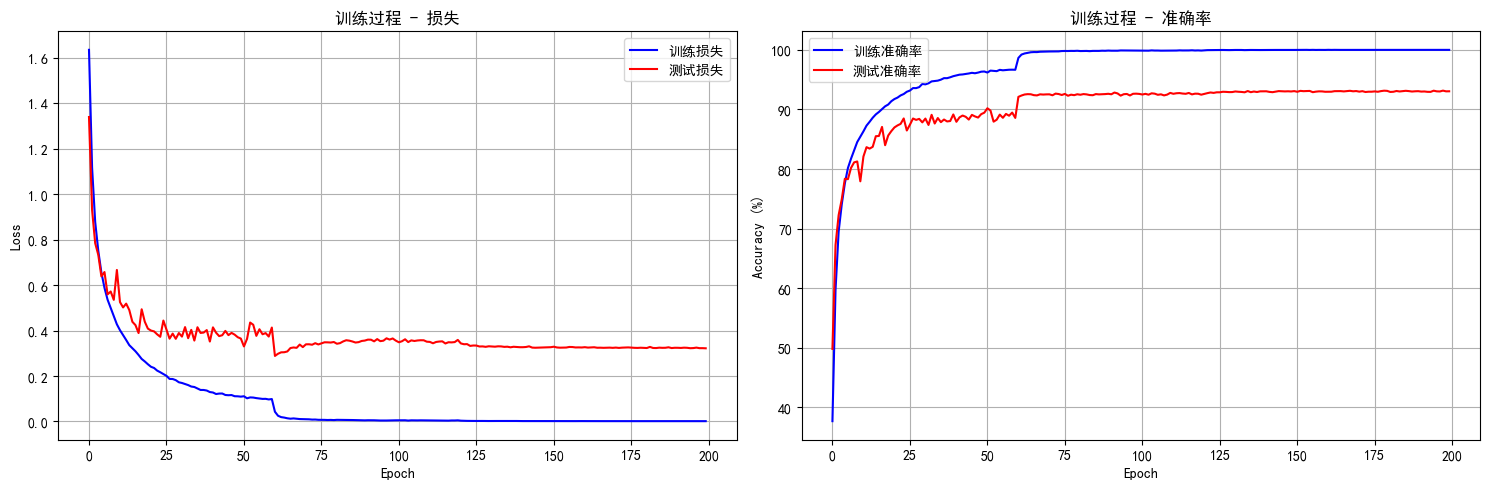

最终训练准确率: 99.99%
最终测试准确率: 93.04%
最佳测试准确率: 93.15%


In [9]:
# 绘制训练过程
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 根据字体设置选择标签文本
if USE_ENGLISH_LABELS:
    train_loss_label = 'Train Loss'
    test_loss_label = 'Test Loss'
    loss_title = 'Training Process - Loss'
    train_acc_label = 'Train Accuracy'
    test_acc_label = 'Test Accuracy'
    acc_title = 'Training Process - Accuracy'
    xlabel_text = 'Epoch'
    ylabel_loss = 'Loss'
    ylabel_acc = 'Accuracy (%)'
    final_train_text = f"Final train accuracy: {train_accs[-1]:.2f}%"
    final_test_text = f"Final test accuracy: {test_accs[-1]:.2f}%"
    best_text = f"Best test accuracy: {max(test_accs):.2f}%"
else:
    train_loss_label = '训练损失'
    test_loss_label = '测试损失'
    loss_title = '训练过程 - 损失'
    train_acc_label = '训练准确率'
    test_acc_label = '测试准确率'
    acc_title = '训练过程 - 准确率'
    xlabel_text = 'Epoch'
    ylabel_loss = 'Loss'
    ylabel_acc = 'Accuracy (%)'
    final_train_text = f"最终训练准确率: {train_accs[-1]:.2f}%"
    final_test_text = f"最终测试准确率: {test_accs[-1]:.2f}%"
    best_text = f"最佳测试准确率: {max(test_accs):.2f}%"

# 损失曲线
ax1.plot(train_losses, label=train_loss_label, color='blue')
ax1.plot(test_losses, label=test_loss_label, color='red')
ax1.set_title(loss_title)
ax1.set_xlabel(xlabel_text)
ax1.set_ylabel(ylabel_loss)
ax1.legend()
ax1.grid(True)

# 准确率曲线
ax2.plot(train_accs, label=train_acc_label, color='blue')
ax2.plot(test_accs, label=test_acc_label, color='red')
ax2.set_title(acc_title)
ax2.set_xlabel(xlabel_text)
ax2.set_ylabel(ylabel_acc)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(final_train_text)
print(final_test_text)
print(best_text)

## 7. 加载最佳模型并进行详细测试

In [10]:
# 加载最佳模型
checkpoint = torch.load(os.path.join(save_dir, 'vgg16_best.pth'))
model.load_state_dict(checkpoint['model_state_dict'])

load_text = f"Best model loaded, test accuracy: {checkpoint['best_acc']:.2f}%" if USE_ENGLISH_LABELS else f"已加载最佳模型，测试准确率: {checkpoint['best_acc']:.2f}%"
print(load_text)

# 计算每个类别的准确率
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# 打印每个类别的准确率
class_acc_text = '\nClass-wise accuracy:' if USE_ENGLISH_LABELS else '\n各类别准确率:'
print(class_acc_text)

for i in range(10):
    if class_total[i] > 0:
        print(f'{classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}% '
              f'({int(class_correct[i])}/{int(class_total[i])})')

已加载最佳模型，测试准确率: 93.15%

各类别准确率:
plane: 95.60% (956/1000)
car: 97.40% (974/1000)
bird: 91.30% (913/1000)
cat: 84.50% (845/1000)
deer: 94.00% (940/1000)
dog: 87.50% (875/1000)
frog: 95.20% (952/1000)
horse: 94.50% (945/1000)
ship: 95.50% (955/1000)
truck: 96.00% (960/1000)

各类别准确率:
plane: 95.60% (956/1000)
car: 97.40% (974/1000)
bird: 91.30% (913/1000)
cat: 84.50% (845/1000)
deer: 94.00% (940/1000)
dog: 87.50% (875/1000)
frog: 95.20% (952/1000)
horse: 94.50% (945/1000)
ship: 95.50% (955/1000)
truck: 96.00% (960/1000)


## 8. 预测示例

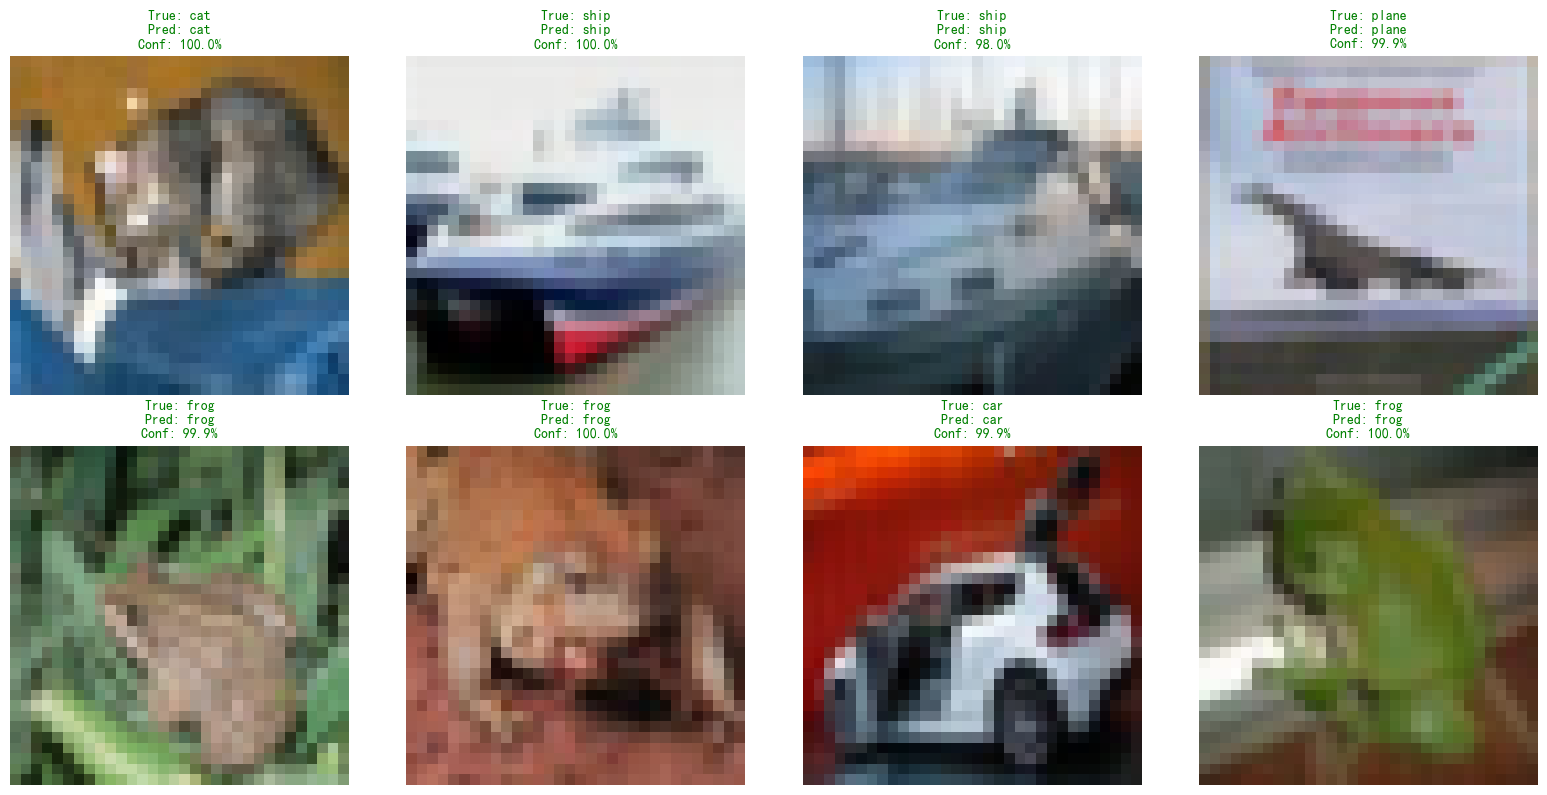

In [11]:
# 随机选择一些测试样本进行预测
def predict_samples(model, testloader, device, num_samples=8):
    model.eval()
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    
    # 显示预测结果
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    for i in range(num_samples):
        ax = axes[i//4, i%4]
        
        # 反标准化图像
        img = images[i].cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = img * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        
        # 设置标题
        true_label = classes[labels[i]]
        pred_label = classes[predicted[i]]
        confidence = probabilities[i][predicted[i]].item() * 100
        
        color = 'green' if predicted[i] == labels[i] else 'red'
        
        if USE_ENGLISH_LABELS:
            title_text = f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%'
        else:
            title_text = f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%'
            
        ax.set_title(title_text, color=color, fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

predict_samples(model, testloader, device)

## 9. 模型性能分析

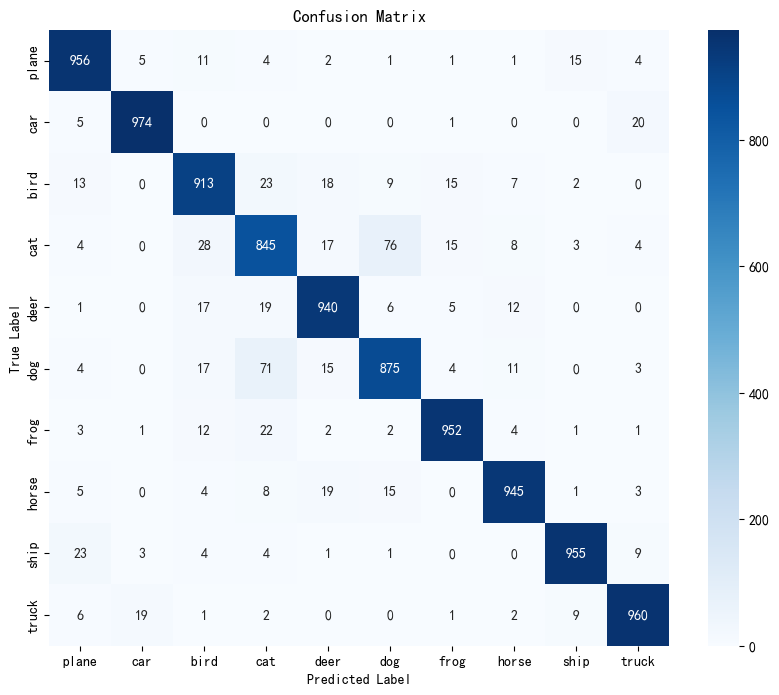

Overall accuracy: 93.15%


In [12]:
# 混淆矩阵
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, testloader, device, classes):
    model.eval()
    all_predicted = []
    all_labels = []
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_predicted)
    
    # 绘制混淆矩阵
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    
    # 根据字体设置选择标题和标签
    if USE_ENGLISH_LABELS:
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        accuracy_text = f"Overall accuracy: {np.sum(np.diag(cm)) / np.sum(cm) * 100:.2f}%"
    else:
        plt.title('Confusion Matrix')  # 使用英文避免字体问题
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        accuracy_text = f"Overall accuracy: {np.sum(np.diag(cm)) / np.sum(cm) * 100:.2f}%"
    
    plt.show()
    
    # 计算总体准确率
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    print(accuracy_text)

plot_confusion_matrix(model, testloader, device, classes)

## 10. 模型信息总结

In [13]:
# 打印模型摘要信息
def model_summary(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print("=" * 50)
    print("VGG16 Model Summary" if USE_ENGLISH_LABELS else "VGG16 模型摘要")
    print("=" * 50)
    
    if USE_ENGLISH_LABELS:
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Model size: {total_params * 4 / (1024**2):.2f} MB")
        print(f"Input size: (3, 32, 32)")
        print(f"Number of classes: 10")
        print("=" * 50)
        print("Training history saved to training_history.json")
        print(f"Best model saved to {save_dir}/vgg16_best.pth")
    else:
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Model size: {total_params * 4 / (1024**2):.2f} MB")
        print(f"Input size: (3, 32, 32)")
        print(f"Number of classes: 10")
        print("=" * 50)
        print("Training history saved to training_history.json")
        print(f"Best model saved to {save_dir}/vgg16_best.pth")

model_summary(model)

# 保存训练历史
import json
history = {
    'train_losses': train_losses,
    'train_accs': train_accs,
    'test_losses': test_losses,
    'test_accs': test_accs,
    'best_accuracy': float(max(test_accs))
}

with open(os.path.join(save_dir, 'training_history.json'), 'w') as f:
    json.dump(history, f, indent=4)

VGG16 模型摘要
Total parameters: 14,990,922
Trainable parameters: 14,990,922
Model size: 57.19 MB
Input size: (3, 32, 32)
Number of classes: 10
Training history saved to training_history.json
Best model saved to ./checkpoints/vgg16_best.pth
